In [1]:

import torch
from tf_toolbox.normalizing_flows.manager import *
import matplotlib.pyplot as plt


In [2]:

def gaussian(x):
    return torch.exp( -torch.sum((x-0.5)**2,axis=-1)/0.3**2 )

In [3]:
n_flow = 2      # number of dimensions


# We define our NormalizingFlow object 
NF =  AffineManager(n_flow=n_flow)



In [4]:
#The model is created
NF.create_model(n_pass_through=1,n_cells=4, nn_width=2, NN=[20,20,20,20,20], roll_step=1)
optim = torch.optim.Adamax(NF.model.parameters(),lr=1e-3, weight_decay=0) #add optimiser



In [5]:
history = NF._train_variance_forward(gaussian,epochs=1000,batch_size=10000,optimizer_object=optim, logdir="./logs/tmp/")

0.1425093561410904


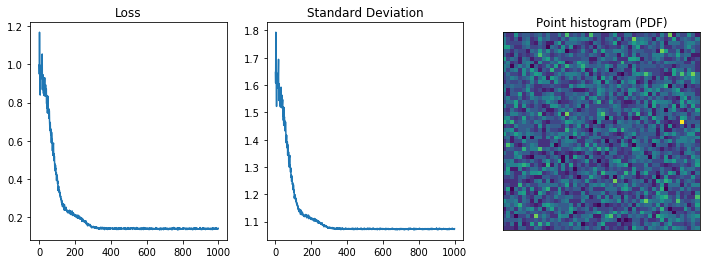

In [6]:
losses=[]
for key, value in history.items():
    losses.append(value["loss"])

fig = plt.figure(figsize=(12, 4))
a1=fig.add_subplot(131)
plt.plot(losses)
print(losses[-1])
a1.title.set_text('Loss')
a2=fig.add_subplot(132)
plt.plot(np.sqrt(np.exp(losses)))
a2.title.set_text('Standard Deviation')

w = torch.empty((10000,2)) 
torch.nn.init.uniform_(w)

w=NF.format_input(w)

X=NF.model(w).data.numpy()

a3=fig.add_subplot(133)
plt.hist2d(X[:,0],X[:,1],bins=50)
a3.set_aspect(aspect=1.)
a3.title.set_text('Point histogram (PDF)')
a3.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the top edge are off
    labelbottom=False,
    labelleft=False)




W
tensor([[0.1749, 0.9668],
        [0.4073, 0.8176],
        [0.9673, 0.7254],
        ...,
        [0.7082, 0.3177],
        [0.7580, 0.2483],
        [0.2512, 0.7041]], requires_grad=True)
with jacob
tensor([[0.1749, 0.9668, 1.0000],
        [0.4073, 0.8176, 1.0000],
        [0.9673, 0.7254, 1.0000],
        ...,
        [0.7082, 0.3177, 1.0000],
        [0.7580, 0.2483, 1.0000],
        [0.2512, 0.7041, 1.0000]], grad_fn=<CatBackward>)
XJ
tensor([[1.3223, 0.1749, 1.3123],
        [1.1089, 0.4073, 1.2933],
        [0.9541, 0.9673, 1.2513],
        ...,
        [0.4523, 0.7082, 1.2700],
        [0.3628, 0.7580, 1.2663],
        [0.9725, 0.2512, 1.3060]], grad_fn=<CatBackward>)
X
tensor([[1.3223, 0.1749],
        [1.1089, 0.4073],
        [0.9541, 0.9673],
        ...,
        [0.4523, 0.7082],
        [0.3628, 0.7580],
        [0.9725, 0.2512]])
torch.Size([10000, 2])
Gaussian:
tensor([1.6852e-04, 1.4771e-02, 8.9398e-03,  ..., 6.0246e-01, 3.8729e-01,
        4.2072e-02])
Gaussian mea